# Inference on Adapter Tuned Gemma

Based on https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora

You will need to set the HF_TOKEN in keys.env (It needs to have WRITE permission)
and accept the Gemma license on http://huggingface.co/google/gemma-3-4b-pt

In [1]:
import os
from dotenv import load_dotenv
load_dotenv("../keys.env")
assert os.environ["HF_TOKEN"][:2] == "hf",\
       "Please specify the HuggingFace access token in keys.env file"

In [2]:
# read image in as Pillow
from PIL import Image
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(Image.open(image).convert("RGB"))
    return image_inputs

## Test model

In [3]:
!head -5 all_data/test/radiology/testdata.csv

id,name,caption
ROCO_00001,PMC4608653_cro-0008-0385-g01.jpg," Axial MRI (coronal view).
"
ROCO_00006,PMC4840839_ol-11-05-3298-g02.jpg," Coronal plain computed tomography image showing multiple large tumor masses with edge enhancement inside the abdominal cavity and liver.
"


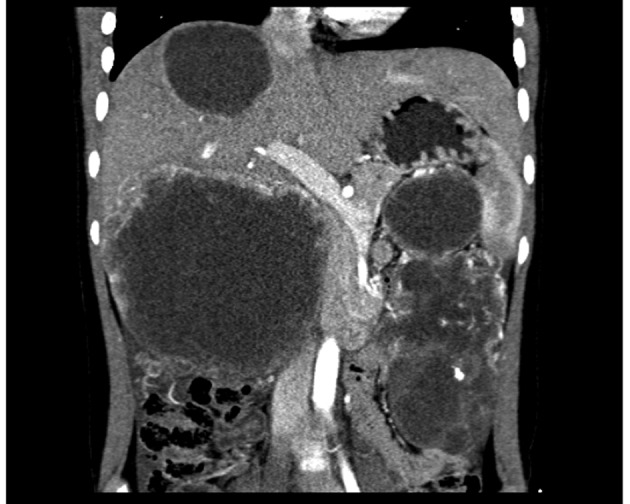

In [4]:
TEST_IMAGE='all_data/test/radiology/images/PMC4840839_ol-11-05-3298-g02.jpg'
from IPython.display import Image as showImage
showImage(filename=TEST_IMAGE)

In [5]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

SFT_OUTDIR="gemma-radiology" # output dir in 3_adapter_tuning.ipynb

# Load Model with PEFT adapter (not the merged model)
model = AutoModelForImageTextToText.from_pretrained(
  SFT_OUTDIR,  
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager",
)
processor = AutoProcessor.from_pretrained(SFT_OUTDIR)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
## Similar to 1_prepare_data.ipynb, except that there is no assistant message (the output)
def format_message(image_filename):
    system_message = "You are an expert researcher in radiology."
    user_prompt = "Write a caption for this image explaining what it depicts, suitable for use in a research publication."
    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_prompt,
                    },
                    {
                        "type": "image",
                        "image": image_filename
                    },
                ],
            },
        ],
    }

In [9]:
import requests
from PIL import Image

def generate_description(image_filename, model, processor):
    # Convert sample into messages and then apply the chat template
    messages = format_message(image_filename)['messages']
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages) # will read into Pillow
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_description(TEST_IMAGE, model, processor)
print(description)

CT scan of the abdomen showing the size and density of the intra-abdominal mass.
